In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import re
import os
import torch
import torch.nn as nn

import math
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from typing import List, Dict, Optional, Union, Tuple
from pathlib import Path

from models  import (
    Block,
    UpSample, 
    DownSample, 
    ResidualBlock, 
    AttentionBlock, 
    Swish, 
    TimeEmbedding,
    DDPMUNet
)

from datasets  import (
    BaseDataset,
    CartoonPretrainDataset,
    Scaler
)

from utils.callbacks import (
    SampleCallback,
    S3SyncCallback,
    DenoiseMidwaySampleCallback,
)

from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, OneCycleLR

from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import (
    EarlyStopping, 
    StochasticWeightAveraging, 
    Callback, 
    ModelCheckpoint,
    LearningRateMonitor,
)

torch.manual_seed(314)
torch.cuda.manual_seed_all(314)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using cuda


In [11]:
## Define hyperparameters
from dotenv import load_dotenv
load_dotenv(override=True)

import wandb

config = dict(
    batch_size = 16,
    accumulate_grad_batches = None,
    use_constant_lr = True,
    lr = 1e-5,
    pokemon_num_epoch = 10_000,
    overfit_batch = 1,
    weight_decay = 0,
    model_type = 'complex',
    infinite_patience = True,
    verbose = False,
    limit_data_size = None,
    dropout = 0.0,
    channels_mult = [1, 2, 2, 2],
    is_attn = [True, True, True, True],
    n_blocks = 1,
    n_steps = 1_000,
    log_wandb = False,
    ema_decay_factor = None,
    use_existing_run = None,
    use_pretrain = None,
    init_new_wandb_run = False,
    is_finetune = False,
    use_grayscale = True,
)

for k, v in config.items():
    if k not in globals() or globals()[k] != v:
        globals()[k] = v

# start a new wandb run to track this script
if log_wandb:
    wandb.login()

    if "run" not in globals():
        run = wandb.init(
            project="diffusion-pokemon-lightning",
            id=use_existing_run if (use_existing_run and not init_new_wandb_run) else None,
            resume="must" if (use_existing_run and not init_new_wandb_run) else None,
            config={
                **config,
                "mode": "offline" if not log_wandb else "online"
            }
        )
        assert run is not None

# some common things
to_pil = transforms.ToPILImage()

# make dictionary of kwargs
unet_kwargs=dict(
    n_blocks=n_blocks, 
    channels_mult=channels_mult, 
    is_attn=is_attn,
    res_block_dropout=dropout,
    model_type=model_type,
    input_channels=3 if not use_grayscale else 1,
)

optimizers_kwargs=dict(
    use_constant_lr=use_constant_lr,
    lr=lr,
    weight_decay=weight_decay,
    num_epochs=pokemon_num_epoch,
)

# Get data

## Pokemon dataset

Number of images loaded:  2503


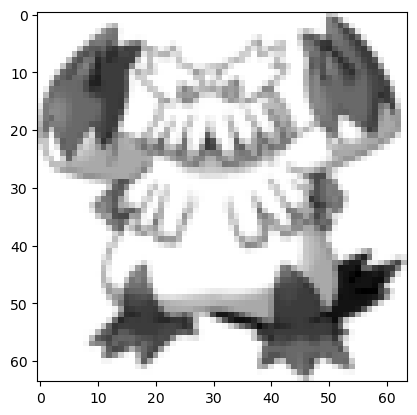

In [32]:
pokemon_dataset = BaseDataset()

pokemon_dataset.init_transform = transforms.Compose([
    transforms.Resize((64, 64)), # smaller image to make model capacity relative larger
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(), 
    Scaler(),
    # transforms.RandomHorizontalFlip(p=0.5) # generative model should not care about left/right
])

pokemon_dataset.load(
    Path(os.getenv("INPUT_DATA_DIR")) / "pokemon-image-dataset" / "images",
    batch_size=batch_size,
    limit_data_size=limit_data_size,
)

try:
    get_ipython()
    img, _ = next(iter(pokemon_dataset.dataset))
    plt.imshow(to_pil((img + 1)/2), cmap="gray" if use_grayscale else None)
    plt.show()
except NameError:
    pass


In [24]:
# split train valid
generator1 = torch.Generator().manual_seed(42)

train_size = int(0.8 * len(pokemon_dataset.dataset))
pokemon_train_dataset, pokemon_valid_dataset = (
    Subset(pokemon_dataset.dataset, list(range(train_size))),
    Subset(pokemon_dataset.dataset, list(range(train_size, len(pokemon_dataset.dataset))))
)

print(f"Train: {len(pokemon_train_dataset)}, Valid: {len(pokemon_valid_dataset)}")

pokemon_train_loader = torch.utils.data.DataLoader(
    pokemon_train_dataset,
    batch_size=batch_size,
    shuffle=True if (overfit_batch is None or overfit_batch < 1) else False,
    num_workers=2,
    pin_memory=True,
)

pokemon_valid_loader = torch.utils.data.DataLoader(
    pokemon_valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

pokemon_img_size = pokemon_train_dataset[0][0].shape[2]
print(f"Pokemon image size: {pokemon_img_size}")

# append steps_per_epoch
effective_batch_size = batch_size * (1 if accumulate_grad_batches is None else accumulate_grad_batches)
num_train_examples = len(pokemon_train_dataset) if overfit_batch is None else (overfit_batch * batch_size)
optimizers_kwargs["steps_per_epoch"] = math.ceil(num_train_examples / effective_batch_size)

Train: 2002, Valid: 501
Pokemon image size: 64


# Init checkpointing and model

In [25]:
# setting up checkpoint 
if 'run' not in globals():
    save_ckpt_local_dir = Path(f"./diffusion-pokemon-lightning/local_run/checkpoints")
else:
    save_ckpt_local_dir = Path(f"./diffusion-pokemon-lightning/{run.id}/checkpoints")
if not save_ckpt_local_dir.exists():
    save_ckpt_local_dir.mkdir(parents=True)

if use_existing_run:
    load_ckpt_local_dir = Path(f"./diffusion-pokemon-lightning/{use_existing_run}/checkpoints")
    if not load_ckpt_local_dir.exists():
        load_ckpt_local_dir.mkdir(parents=True)
else:
    load_ckpt_local_dir = None

s3_sync_callback = S3SyncCallback(
    save_local_dir=save_ckpt_local_dir, 
    load_local_dir=load_ckpt_local_dir, 
    every_n_epochs=100
)

if use_existing_run:
    s3_sync_callback.download_files_from_s3()
    
if use_pretrain and not use_existing_run: # if resuming run, no need to pretrain
    pretrain_ckpt_path = (Path(".") / use_pretrain)
    pretrain_ckpt_local_dir = pretrain_ckpt_path.parent
    if not pretrain_ckpt_local_dir.exists():
        pretrain_ckpt_local_dir.mkdir(parents=True)
        
    s3_pretrain_sync = S3SyncCallback(save_local_dir=pretrain_ckpt_local_dir, load_local_dir=pretrain_ckpt_local_dir)
    s3_pretrain_sync.download_filename(pretrain_ckpt_path.name)
    
    assert pretrain_ckpt_path.exists()
    
    state_dict = torch.load(pretrain_ckpt_path)
    model = DDPMUNet(
        n_steps=n_steps,
        input_size=pokemon_img_size,
        optimizers_kwargs=optimizers_kwargs,
        unet_kwargs=unet_kwargs,
        is_finetune=is_finetune
    )
    model.load_state_dict(state_dict["state_dict"])
    model = model.to(device)
    
else:
    model = DDPMUNet(
        n_steps=n_steps,
        input_size=pokemon_img_size,
        optimizers_kwargs=optimizers_kwargs,
        unet_kwargs=unet_kwargs,
        is_finetune=is_finetune
    ).to(device)
    
print("Number of params:", sum(p.numel() for p in model.eps_model.parameters()))
print("Model device:", model.device)

Initialised S3 sync. Saving to: diffusion-pokemon-lightning\local_run\checkpoints and loading from: diffusion-pokemon-lightning\local_run\checkpoints
Number of params: 6869697
Model device: cuda:0


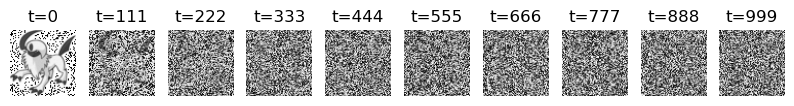

In [37]:
# test model forward noising
sample_img = pokemon_train_dataset[10][0]

num_imgs = 10
ts = torch.as_tensor(np.round(np.linspace(0, model.n_steps-1, num_imgs)), dtype=torch.long).to(model.device)
x = torch.unsqueeze(sample_img, 0).expand(num_imgs, *sample_img.shape).to(model.device)
true_noise_e = torch.randn_like(x).to(model.device)
noised_x_t = model.noise_sample_at_timestep(x, ts, true_noise_e).cpu()

fig, axs = plt.subplots(ncols=num_imgs, nrows=1, figsize=(num_imgs, 1))
for idx, ax in enumerate(axs):
    ax.imshow(to_pil((noised_x_t[idx] + 1)/2), cmap="gray" if use_grayscale else None)
    ax.grid(False)
    ax.axis(False)
    ax.set_title(f"t={str(ts[idx].item())}")
    
plt.show()

# Train

In [35]:
callbacks = [s3_sync_callback]

if log_wandb:
    pokemon_logger = WandbLogger(
        project="diffusion-pokemon-lightning",
        prefix="pokemon"
    )

    try:
        pokemon_logger.watch(model)
    except ValueError as e:
        if "You can only call `wandb.watch` once per model." not in str(e):
            raise e

if log_wandb:
    sampling_freq = 1_000
    sample_callback = SampleCallback(freq=sampling_freq, logger=pokemon_logger, mode="L" if use_grayscale else None)
    denoise_callback = DenoiseMidwaySampleCallback(
        logger=pokemon_logger, 
        seed_img_transformed=sample_img,
        noise_at_ts=[900, 500, 100],
        freq=sampling_freq,
        mode="L" if use_grayscale else None
    )
    callbacks.extend([sample_callback, denoise_callback])

checkpoint_callback = ModelCheckpoint(
    dirpath=save_ckpt_local_dir,
    filename="{epoch}-{step}",
    save_last=True,
    every_n_epochs=25,
    save_on_train_epoch_end=True,
)
callbacks.append(checkpoint_callback)

if log_wandb:
    lr_monitor = LearningRateMonitor(logging_interval='step')
    callbacks.append(lr_monitor)

trainer = Trainer(
    accelerator="gpu" if device == "cuda" else "cpu", 
    devices=1, 
    max_epochs=pokemon_num_epoch,
    log_every_n_steps=20,
    precision=32,
    logger=pokemon_logger if log_wandb else None,
    callbacks=callbacks,
    accumulate_grad_batches=accumulate_grad_batches if accumulate_grad_batches else 1,
    overfit_batches=overfit_batch,
    max_time="00:08:00:00"
)

trainer.fit(
    model, 
    train_dataloaders=pokemon_train_loader,
    val_dataloaders=pokemon_valid_loader,   
    ckpt_path=(load_ckpt_local_dir/'last.ckpt') if use_existing_run else None
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0 | loss      | MSELoss | 0     
1 | eps_model | UNet    | 6.9 M 
--------------------------------------
6.9 M     Trainable params
0         Non-trainable params
6.9 M     Total params
27.479    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\hoang\miniconda3\envs\diffusion_pokemon\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


c:\Users\hoang\miniconda3\envs\diffusion_pokemon\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\hoang\miniconda3\envs\diffusion_pokemon\lib\site-packages\pytorch_lightning\loops\fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=20). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s, v_num=1]        

c:\Users\hoang\miniconda3\envs\diffusion_pokemon\lib\site-packages\pytorch_lightning\trainer\call.py:52: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x00000255401284C0>
Traceback (most recent call last):
  File "c:\Users\hoang\miniconda3\envs\diffusion_pokemon\lib\site-packages\torch\utils\data\dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "c:\Users\hoang\miniconda3\envs\diffusion_pokemon\lib\site-packages\torch\utils\data\dataloader.py", line 1436, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


In [36]:
if log_wandb:
    wandb.finish()